In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

# Extract data from source

In [2]:
# get stock data for Apple
data = yf.download('AAPL', start = '2015-01-01', end = '2021-01-01')

[*********************100%***********************]  1 of 1 completed


# Data for analysis

In [3]:
#get only 'Adj Close','Volume'
stock = data['Adj Close'].copy()

In [4]:
#set higher frequency to business days
stock = stock.asfreq('b')

# Inspecting stock price data 

In [5]:
#check for any nulls
stock.isnull().sum()

54

In [6]:
#fills nulls with backfill method
stock = stock.fillna(method = 'backfill')

In [7]:
#check for any nulls after fill na has been applied
stock.isnull().sum()

0

<AxesSubplot:title={'center':'Apple Stock'}, xlabel='Date'>

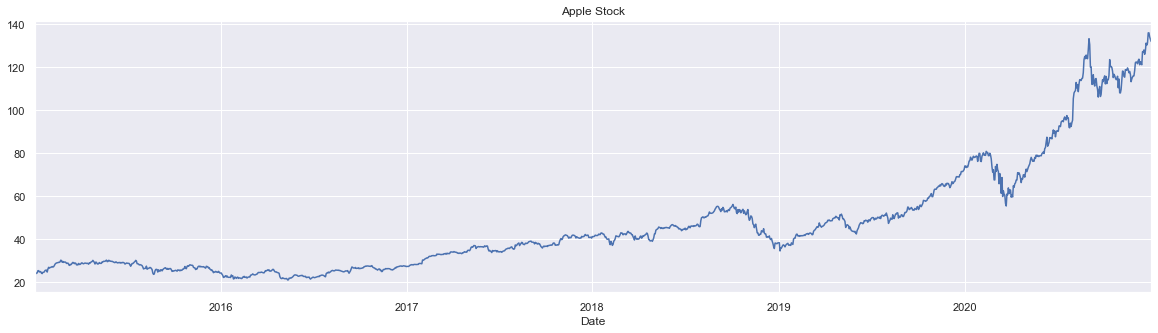

In [8]:
# inspect visually
stock.plot(figsize = (20,5), title = 'Apple Stock')

In [9]:
# descriptive stats
stock.describe()

count   1565.00
mean      46.51
std       25.52
min       21.07
25%       27.59
50%       39.82
75%       52.35
max      136.05
Name: Adj Close, dtype: float64

In [10]:
#QQ Plot - How the data fits a normal distribution
#scipy.stats.probplot(stock, plot = pylab)
#pylab.show()

In [11]:
#Determining weak form stationarity
sts.adfuller(stock)

(2.278813694140191,
 0.9989413291656689,
 24,
 1540,
 {'1%': -3.4346033983723516,
  '5%': -2.863418614437511,
  '10%': -2.5677701454714117},
 4806.218943314432)

# Create AR Model Using % Returns

In [12]:
# Using Returns
stock_r = stock.pct_change(1).mul(100)
stock_r = stock_r.iloc[1:]
stock_r = stock_r.asfreq('b')
stock_r = stock_r.to_frame('returns')

<AxesSubplot:title={'center':'Apple Returns'}, xlabel='Date'>

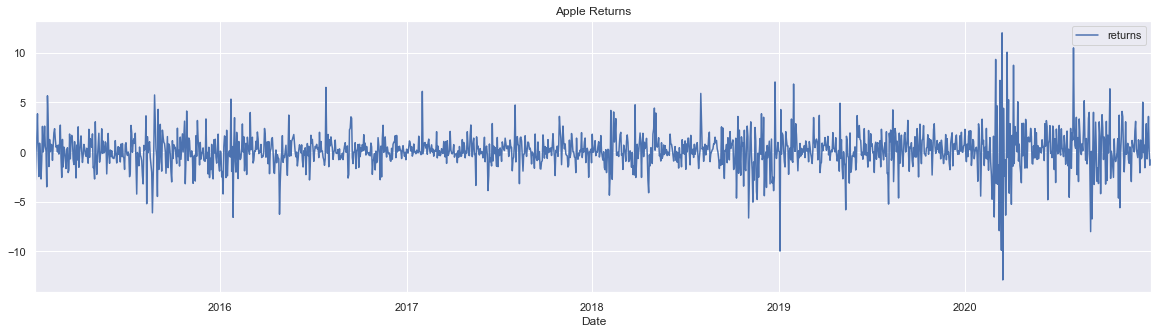

In [13]:
# inspect visually after converted to retunrs
stock_r.plot(figsize = (20,5), title = 'Apple Returns')

In [14]:
#plot a white noise process to compare
#wn = np.random.normal(loc = stock_r.mean(), scale = stock_r.std(), size = len(stock_r))
#stock_r['wn'] = wn

In [15]:
#plot a white noise process and runs tests to compare
#stock_r.wn.plot(figsize = (20,5), title = 'white noise')
#sts.adfuller(stock_r.wn)
#stock_r.drop(['wn'], axis = 1, inplace = True)

In [16]:
#QQ Plot - How the data fits a normal distribution after transformed to returns
#scipy.stats.probplot(stock_r.returns, plot = pylab)
#pylab.show()

In [17]:
#Determining weak form stationarity for returns
sts.adfuller(stock_r.returns)
#stock_r.plot(figsize = (20,5), title = 'Apple Stock returns')

(-12.07000672684162,
 2.359780969439154e-22,
 8,
 1555,
 {'1%': -3.4345623007753496,
  '5%': -2.8634004754910296,
  '10%': -2.567760486450719},
 6190.025465683406)

In [18]:
# descriptive stats of returns
stock_r.describe()

,returns
count,1564.00
mean,0.12
std,1.83
min,-12.86
25%,-0.59
50%,0.04
75%,0.96
max,11.98


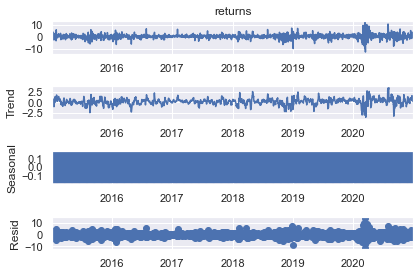

In [19]:
#naive seasonal decomposition --requires at least 2 complete cycles
s_dec_additive = seasonal_decompose(stock_r.returns, model = 'additive')
s_dec_additive.plot()
plt.show()

In [20]:
#naive seasonal decomposition --requires at least 2 complete cycles & not appropiate for 0 or negative values
#s_dec_multiplicative = seasonal_decompose(stock_r, model = 'multiplicative')
#s_dec_additive.plot()
#plt.show()

In [21]:
#ACF --not appropiate for AR models
#sgt.plot_acf(stock_r, lags = 40 , zero = False)
#plt.title('ACF', size = 24)
#plt.show()

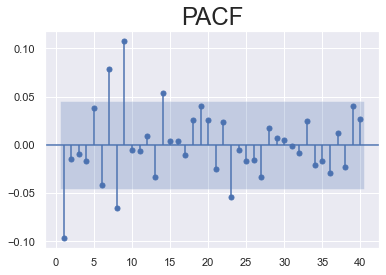

In [22]:
#PACF -- Appropiate for AR model
sgt.plot_pacf(stock_r, lags = 40 , zero = False, method = ('ld'), alpha=0.07 )
plt.title('PACF', size = 24)
plt.show()

In [23]:
# autocorrelation
#autocorrelation_plot(stock_r)

In [24]:
#d & q = 0 makes ARIMA into AR model
model_ar_1 = ARIMA(stock_r, order = (1,0,0))
model_ar_7 = ARIMA(stock_r, order = (7,0,0))
model_ar_8 = ARIMA(stock_r, order = (8,0,0))
model_ar_9 = ARIMA(stock_r, order = (9,0,0))
model_ar_14 = ARIMA(stock_r, order = (14,0,0))

In [25]:
# fits models
results_ar_1 = model_ar_1.fit()
results_ar_7 = model_ar_7.fit()
results_ar_8 = model_ar_8.fit()
results_ar_9 = model_ar_9.fit()
results_ar_14 = model_ar_14.fit()

In [26]:
#Log Likelihood-ratio test function
from scipy.stats import chi2
def LLR_Test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2 - L1))
    P = chi2.sf(LR, DF).round(3)
    return P

In [27]:
#Selecting best model 
print (' Log Likelihood-ratio & Akaike information criterion')
print(' \n AR lag 1 \tLL =',results_ar_1.llf,' \tAIC =',results_ar_1.aic)
print(' AR lag 7 \tLL =',results_ar_7.llf,'\tAIC =',results_ar_7.aic)
print(' AR lag 8 \tLL =',results_ar_8.llf,'\tAIC =',results_ar_8.aic)
print(' AR lag 9 \tLL =',results_ar_9.llf,'\tAIC =',results_ar_9.aic)
print(' AR lag 14 \tLL =',results_ar_14.llf,'\tAIC =',results_ar_14.aic)
print ('\n Statistical significance of delta in Log Likelihood-ratio')
print('\n AR 1 v AR 7 \tLLR Test P-Value:' + str(LLR_Test(model_ar_1,model_ar_7, DF = 6)))
print(' AR 7 v AR 8 \tLLR Test P-Value:' + str(LLR_Test(model_ar_7,model_ar_8)))
print(' AR 8 v AR 9 \tLLR Test P-Value:' + str(LLR_Test(model_ar_8,model_ar_9)))
print(' AR 9 v AR 14 \tLLR Test P-Value:' + str(LLR_Test(model_ar_9,model_ar_14, DF = 5)))

 Log Likelihood-ratio & Akaike information criterion
 
 AR lag 1 	LL = -3160.1418983463727  	AIC = 6326.283796692745
 AR lag 7 	LL = -3152.3677439056983 	AIC = 6322.7354878113965
 AR lag 8 	LL = -3149.1031257482086 	AIC = 6318.206251496417
 AR lag 9 	LL = -3140.0808876445453 	AIC = 6302.161775289091
 AR lag 14 	LL = -3136.8522484289015 	AIC = 6305.704496857803

 Statistical significance of delta in Log Likelihood-ratio

 AR 1 v AR 7 	LLR Test P-Value:0.016
 AR 7 v AR 8 	LLR Test P-Value:0.011
 AR 8 v AR 9 	LLR Test P-Value:0.0
 AR 9 v AR 14 	LLR Test P-Value:0.264


In [28]:
#Summary of the best fitting model
print(results_ar_9.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -3140.081
Date:                Thu, 04 Nov 2021   AIC                           6302.162
Time:                        17:19:36   BIC                           6361.067
Sample:                    01-05-2015   HQIC                          6324.060
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1241      0.048      2.575      0.010       0.030       0.219
ar.L1         -0.0810      0.018     -4.590      0.000      -0.116      -0.046
ar.L2         -0.0289      0.017     -1.727      0.0

# Residuals of Returns

In [29]:
#Analyzing residuals 
mod_res = model_ar_9.fit().resid

In [30]:
#Desc stats of residuals--stats of interest are mean and std
mod_res.describe()

count   1564.00
mean      -0.00
std        1.80
min      -11.11
25%       -0.77
50%       -0.03
75%        0.90
max       10.06
dtype: float64

In [31]:
#Determining weak form stationarity for residuals
sts.adfuller(mod_res)

(-39.52005262698881,
 0.0,
 0,
 1563,
 {'1%': -3.4345407051300514,
  '5%': -2.863390943879109,
  '10%': -2.567755410866859},
 6174.216473114461)

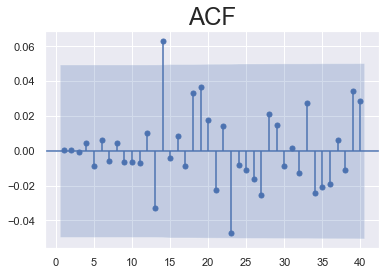

In [32]:
#ACF of residuals for returns
sgt.plot_acf(mod_res, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

<AxesSubplot:xlabel='Date'>

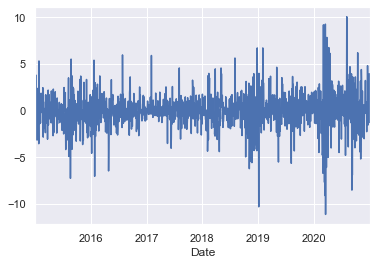

In [33]:
mod_res.plot()

# Create AR Models Using Normalized % Returns

In [34]:
#Create benchmark
benchmark = stock_r.iloc[0]

In [35]:
#normalize
stock_rn = stock_r.div(benchmark).mul(100)

In [36]:
# descriptive stats of normalized returns
stock_rn.describe()

,returns
count,1564.00
mean,-4.40
std,65.11
min,-425.28
25%,-34.03
50%,-1.50
75%,21.04
max,456.66


In [37]:
#check for stationarity
sts.adfuller(stock_rn)

(-12.070006726841623,
 2.3597809694391206e-22,
 8,
 1555,
 {'1%': -3.4345623007753496,
  '5%': -2.8634004754910296,
  '10%': -2.567760486450719},
 17176.76923726913)

<AxesSubplot:title={'center':'Normalized Apple Returns'}, xlabel='Date'>

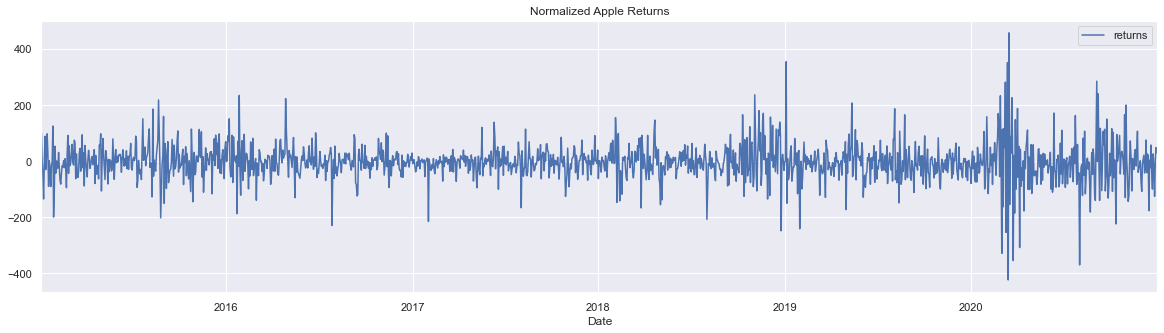

In [38]:
# inspect visually after converted to retunrs
stock_rn.plot(figsize = (20,5), title = 'Normalized Apple Returns')

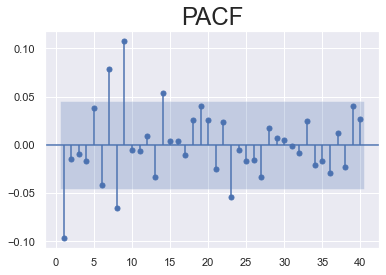

In [39]:
#PACF normalized returns
sgt.plot_pacf(stock_rn, lags = 40 , zero = False, method = ('ld'), alpha=0.07 )
plt.title('PACF', size = 24)
plt.show()

In [40]:
#d & q = 0 makes ARIMA into AR model
model_arn_1 = ARIMA(stock_rn, order = (1,0,0))
model_arn_7 = ARIMA(stock_rn, order = (7,0,0))
model_arn_8 = ARIMA(stock_rn, order = (8,0,0))
model_arn_9 = ARIMA(stock_rn, order = (9,0,0))
model_arn_14 = ARIMA(stock_rn, order = (14,0,0))

In [41]:
# fits models
results_arn_1 = model_arn_1.fit()
results_arn_7 = model_arn_7.fit()
results_arn_8 = model_arn_8.fit()
results_arn_9 = model_arn_9.fit()
results_arn_14 = model_arn_14.fit()

In [42]:
#Selecting best model 
print (' Log Likelihood-ratio & Akaike information criterion')
print(' \n AR lag 1 \tLL =',results_arn_1.llf,' \tAIC =',results_arn_1.aic)
print(' AR lag 7 \tLL =',results_arn_7.llf,'\tAIC =',results_arn_7.aic)
print(' AR lag 8 \tLL =',results_arn_8.llf,' \tAIC =',results_arn_8.aic)
print(' AR lag 9 \tLL =',results_arn_9.llf,'\tAIC =',results_arn_9.aic)
print(' AR lag 14 \tLL =',results_arn_14.llf,'\tAIC =',results_arn_14.aic)
print ('\n Statistical significance of delta in Log Likelihood-ratio')
print('\n AR 1 v AR 7 \tLLR Test P-Value:' + str(LLR_Test(model_arn_1,model_arn_7, DF = 6)))
print(' AR 7 v AR 8 \tLLR Test P-Value:' + str(LLR_Test(model_arn_7,model_arn_8)))
print(' AR 8 v AR 9 \tLLR Test P-Value:' + str(LLR_Test(model_arn_8,model_arn_9)))
print(' AR 9 v AR 14 \tLLR Test P-Value:' + str(LLR_Test(model_arn_9,model_arn_14, DF = 5)))

 Log Likelihood-ratio & Akaike information criterion
 
 AR lag 1 	LL = -8742.750253636532  	AIC = 17491.500507273064
 AR lag 7 	LL = -8734.976572937943 	AIC = 17487.953145875887
 AR lag 8 	LL = -8731.711368153552  	AIC = 17483.422736307104
 AR lag 9 	LL = -8722.690666723014 	AIC = 17467.38133344603
 AR lag 14 	LL = -8719.460811643767 	AIC = 17470.921623287533

 Statistical significance of delta in Log Likelihood-ratio

 AR 1 v AR 7 	LLR Test P-Value:0.016
 AR 7 v AR 8 	LLR Test P-Value:0.011
 AR 8 v AR 9 	LLR Test P-Value:0.0
 AR 9 v AR 14 	LLR Test P-Value:0.264


In [43]:
#Summary of the best fitting model
print(results_arn_9.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -8722.691
Date:                Thu, 04 Nov 2021   AIC                          17467.381
Time:                        17:19:44   BIC                          17526.286
Sample:                    01-05-2015   HQIC                         17489.280
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3971      1.707     -2.576      0.010      -7.743      -1.051
ar.L1         -0.0810      0.018     -4.601      0.000      -0.116      -0.047
ar.L2         -0.0289      0.017     -1.730      0.0

# Residuals of Normalized Returns

In [44]:
#Analyzing residuals 
mod_resn = model_arn_9.fit().resid

In [45]:
#Desc stats of residuals--stats of interest are mean and std
mod_res.describe()

count   1564.00
mean      -0.00
std        1.80
min      -11.11
25%       -0.77
50%       -0.03
75%        0.90
max       10.06
dtype: float64

In [46]:
#Determining weak form stationarity for residuals
sts.adfuller(mod_resn)

(-39.519545876910755,
 0.0,
 0,
 1563,
 {'1%': -3.4345407051300514,
  '5%': -2.863390943879109,
  '10%': -2.567755410866859},
 17160.95980230043)

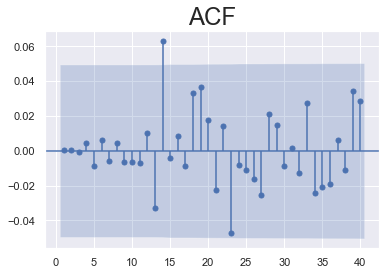

In [47]:
#ACF of residuals for returns
sgt.plot_acf(mod_resn, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

<AxesSubplot:xlabel='Date'>

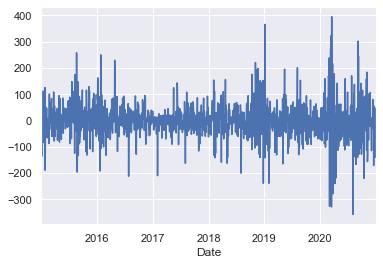

In [48]:
mod_resn.plot()